# Imports

In [3]:
import numpy as np
import networkx as nx
from sklearn.linear_model import LinearRegression
from pyod.models.lof import LOF
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.utils import from_scipy_sparse_matrix
import scipy.io
import matplotlib.pyplot as plt
import torch
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

# Exercise 1

In [12]:
data = np.loadtxt("ca-AstroPh.txt", dtype=np.int32)

G = nx.Graph()

for n1, n2 in data:
    if G.has_edge(n1, n2):
        attr = G.get_edge_data(n1, n2)
        weight = attr["weight"]
        G.remove_edge(n1, n2)
        G.add_edge(n1, n2, weight=weight+1)
    else:
        G.add_edge(n1, n2, weight=1)

In [13]:
attrs = {}

for node in G:
    egonet = nx.ego_graph(G, node)

    N = len(egonet.nodes) - 1
    E = len(egonet.edges)
    W = egonet.size(weight="weight")

    adj_matrix = nx.adjacency_matrix(egonet, weight="weight").toarray()
    eigenvalues, _ = np.linalg.eigh(adj_matrix)
    eig = eigenvalues[0]

    attrs[node] = {
        "N": N, 
        "E": E,
        "W": W,
        "lambda": eig
    }

nx.set_node_attributes(G, attrs)

In [14]:
X = []
y = []

for node, attr in G.nodes(data=True):
    if attr["N"] > 0 and attr["E"] > 0:  
        X.append([np.log(attr["N"])])
        y.append(np.log(attr["E"]))

X = np.array(X)
y = np.array(y)

model = LinearRegression()
model.fit(X, y)

anomaly_scores = {}
for node, attr in G.nodes(data=True):
    if attr["N"] > 0 and attr["E"] > 0:  
        N_log = np.log(attr["N"])
        E_log = np.log(attr["E"])
        E_pred_log = model.predict([[N_log]])[0]
        
        score = max(E_log, E_pred_log) / min(E_log, E_pred_log) * np.log(abs(E_log - E_pred_log) + 1)
        anomaly_scores[node] = score

nx.set_node_attributes(G, anomaly_scores, "anomaly_score")

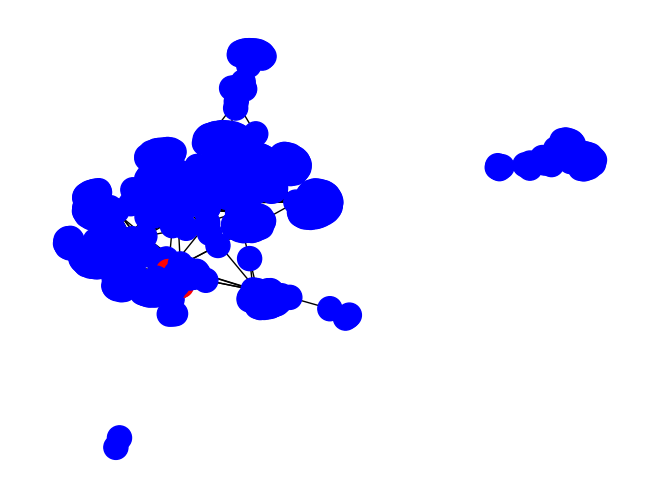

In [15]:
sorted_nodes = sorted(anomaly_scores.items(), key=lambda x: x[1], reverse=True)

top_10_nodes = [node for node, score in sorted_nodes[:10]]

subgraph_edges = data[:1500]
subgraph = nx.Graph()
subgraph.add_edges_from(subgraph_edges)

pos = nx.spring_layout(subgraph)
node_colors = ["red" if node in top_10_nodes else "blue" for node in subgraph.nodes()]
nx.draw(subgraph, pos, node_color=node_colors)

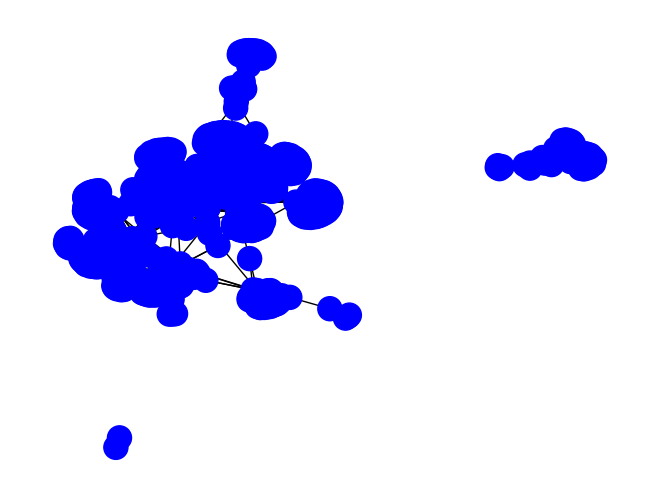

In [18]:
X_lof = np.column_stack((X, y))

lof = LOF()
lof.fit(X_lof)

lof_scores = lof.decision_function(X_lof)
scaler = MinMaxScaler()
norma_anomaly_scores = scaler.fit_transform(np.array(list(anomaly_scores.values())).reshape(-1, 1)).flatten()

combined_scores = norma_anomaly_scores + lof_scores

for i, (node, score) in enumerate(anomaly_scores.items()):
    anomaly_scores[node] = combined_scores[i]

nx.set_node_attributes(G, anomaly_scores, "anomaly_score")

sorted_nodes = sorted(anomaly_scores.items(), key=lambda x: x[1], reverse=True)
top_10_nodes = [node for node, score in sorted_nodes[:10]]

node_colors = ["red" if node in top_10_nodes else "blue" for node in subgraph.nodes()]
nx.draw(subgraph, pos, node_color=node_colors)

# Exercise 2

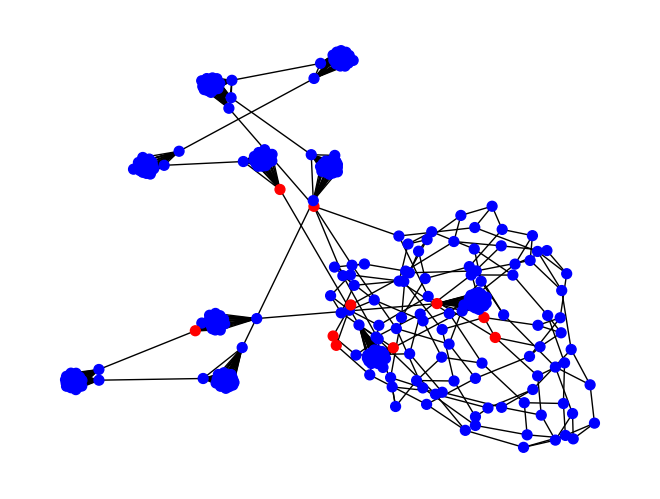

In [21]:
regular_graph = nx.random_regular_graph(3, 100)
caveman_graph = nx.connected_caveman_graph(10, 20)

merged_graph = nx.union(regular_graph, caveman_graph, rename=("r", "c-"))

while not nx.is_connected(merged_graph):
    node1 = np.random.choice(merged_graph.nodes())
    node2 = np.random.choice(merged_graph.nodes())
    if node1 != node2 and not merged_graph.has_edge(node1, node2):
        merged_graph.add_edge(node1, node2)

attrs = {}
for node in merged_graph:
    egonet = nx.ego_graph(merged_graph, node)
    N = len(egonet.nodes) - 1
    E = len(egonet.edges)
    W = egonet.size(weight="weight")
    adj_matrix = nx.adjacency_matrix(egonet, weight="weight").toarray()
    eigenvalues, _ = np.linalg.eigh(adj_matrix)
    eig = eigenvalues[0]
    attrs[node] = {"N": N, "E": E, "W": W, "lambda": eig}

nx.set_node_attributes(merged_graph, attrs)

X = []
y = []
for node, attr in merged_graph.nodes(data=True):
    if attr["N"] > 0 and attr["E"] > 0:
        X.append([np.log(attr["N"])])
        y.append(np.log(attr["E"]))

X = np.array(X)
y = np.array(y)

model = LinearRegression()
model.fit(X, y)

anomaly_scores = {}
for node, attr in merged_graph.nodes(data=True):
    if attr["N"] > 0 and attr["E"] > 0:
        N_log = np.log(attr["N"])
        E_log = np.log(attr["E"])
        E_pred_log = model.predict([[N_log]])[0]
        score = max(E_log, E_pred_log) / min(E_log, E_pred_log) * np.log(abs(E_log - E_pred_log) + 1)
        anomaly_scores[node] = score

nx.set_node_attributes(merged_graph, anomaly_scores, "anomaly_score")

sorted_nodes = sorted(anomaly_scores.items(), key=lambda x: x[1], reverse=True)
top_10_nodes = [node for node, score in sorted_nodes[:10]]

pos = nx.spring_layout(merged_graph)
node_colors = ["red" if node in top_10_nodes else "blue" for node in merged_graph.nodes()]
nx.draw(merged_graph, pos, node_color=node_colors, with_labels=False, node_size=50)
plt.show()

# Exercise 3

In [22]:
acm_data = scipy.io.loadmat("ACM.mat")

attributes = acm_data["Attributes"]
adj_matrix = acm_data["Network"]
labels = acm_data["Label"]

edge_index, edge_weight = from_scipy_sparse_matrix(adj_matrix)

In [26]:
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return x

class AttributeDecoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(AttributeDecoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return x

class StructureDecoder(nn.Module):
    def __init__(self, in_channels):
        super(StructureDecoder, self).__init__()
        self.conv = GCNConv(in_channels, in_channels)

    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        x = F.relu(x)
        ret = torch.matmul(x, x.t())
        return ret

class GraphAutoencoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphAutoencoder, self).__init__()
        self.encoder = Encoder(in_channels, hidden_channels, out_channels)
        self.attr_decoder = AttributeDecoder(out_channels, hidden_channels, in_channels)
        self.struct_decoder = StructureDecoder(out_channels)

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        x_hat = self.attr_decoder(z, edge_index)
        adj_hat = self.struct_decoder(z, edge_index)
        return x_hat, adj_hat

In [27]:
def loss_function(X, X_hat, A, A_hat, alpha=0.8):
    attribute_loss = torch.norm(X - X_hat, p="fro") ** 2
    structure_loss = torch.norm(A - A_hat, p="fro") ** 2
    
    loss = alpha * attribute_loss + (1 - alpha) * structure_loss
    return loss

In [ ]:
in_channels = attributes.shape[1]
hidden_channels = 64
out_channels = 32
model = GraphAutoencoder(in_channels, hidden_channels, out_channels)

optimizer = torch.optim.Adam(model.parameters(), lr=0.004)

attributes_dense = torch.tensor(attributes.todense(), dtype=torch.float32)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    x_hat, adj_hat = model(attributes_dense, edge_index)
    
    loss = loss_function(attributes_dense, x_hat, adj_matrix.toarray(), adj_hat)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            x_hat, adj_hat = model(attributes_dense, edge_index)
            reconstruction_errors = torch.norm(attributes_dense - x_hat, dim=1).numpy()
            roc_auc = roc_auc_score(labels, reconstruction_errors)
            print(f"Epoch {epoch}, Loss: {loss.item()}, ROC AUC: {roc_auc}")